In [61]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [160]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([0.1, 0.9, 0.8, 0.4, 0.5])

sf = np.array([[[0.5, 0.1, 0.05],
                [0.6, 0.1, 0.05],
                [0.7, 0.1, 0.05],
                [0.8, 0.1, 0.05],
                [0.9, 0.1, 0.05]],
               [[0.5, 0.2, 0.0],
                [0.6, 0.2, 0.0],
                [0.7, 0.2, 0.0],
                [0.8, 0.2, 0.0],
                [0.9, 0.2, 0.0]]])

# sf = np.array([[[0.5],
#                 [0.6],
#                 [0.7],
#                 [0.8],
#                 [0.9],
#                [[0.1],
#                 [0.2],
#                 [0.3],
#                 [0.4],
#                 [0.5]]]])

sf = np.array([[0.5, 0.6, 0.7, 0.8, 0.9],
               [0.1, 0.2, 0.3, 0.4, 0.5]])

weights = np.vstack([a, b]).T
print(sf.shape, weights.shape)
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

(2, 5) (5, 2)


array([[0.46363636, 1.25454545, 2.12727273, 3.05454545, 4.31818182],
       [0.17586207, 0.47586207, 0.80689655, 1.15862069, 1.63793103],
       [0.13421053, 0.36315789, 0.61578947, 0.88421053, 1.25      ],
       [0.11590909, 0.31363636, 0.53181818, 0.76363636, 1.07954545],
       [0.09272727, 0.25090909, 0.42545455, 0.61090909, 0.86363636]])

In [150]:
np.mean(weights, axis=0)

array([3.  , 0.54])

In [156]:
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

array([[0.5       , 0.10909091, 0.04545455],
       [0.6       , 0.13103448, 0.03448276],
       [0.7       , 0.12105263, 0.03947368],
       [0.8       , 0.10909091, 0.04545455],
       [0.9       , 0.10909091, 0.04545455]])

In [118]:
np.dot(sf.T, weights.T).shape

(3, 5, 5)

In [122]:
sf.T.shape

(3, 5, 2)

In [121]:
(weights @ sf)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 2)

In [141]:
np.tensordot(weights.T, sf.T, axes=0).shape

(2, 5, 3, 5, 2)

In [210]:
from survivors.tree import CRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None
        
    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        sf = self.predict_at_times(X, self.bins, mode="surv")
        ibs_v = metr.ibs(y, y, sf, self.bins, axis=0)

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
        self.ibs_leaf[counts>0]/=counts[counts>0]
        self.ibs_mean = np.mean(ibs_v)
    
    def get_ibs_by_leaf(self, X, divide=False):
        numbs = self.predict(X, target="numb").astype("int")
        if divide:
            return self.ibs_leaf[numbs] / self.ibs_mean
        return self.ibs_leaf[numbs]
    
    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)

In [378]:
a = np.array([[1, 0.5, 0.3],
          [2, 0.8, 0.1],
          [3, 0.2, 0.9]])
(a - np.array([0, 1, 2])) / np.array([1, 2, 4])

array([[ 1.   , -0.25 , -0.425],
       [ 2.   , -0.1  , -0.475],
       [ 3.   , -0.4  , -0.275]])

In [891]:
from survivors.ensemble import BoostingCRAID
from scipy.stats import norm

class IBSBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.zeros(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.ibs_means = []
        self.ibs_stds = []
        self.update_params()
        
        for i in range(self.n_estimators):
            if self.with_arc:
                prob_weights = arc_x4(self.weights)
            else:
                prob_weights = self.weights
            if i == 0:
                self.ibs_means.append(0.0)
                self.ibs_stds.append(1.0)
                prob_weights = np.ones(self.weights.shape)*0.5
            else:
                self.ibs_means.append(np.mean(self.weights))
                self.ibs_stds.append(np.std(self.weights))
            # wei = (self.weights - self.ibs_means[-1]) / self.ibs_stds[-1]
#             prob_weights = norm.cdf(wei)
#             plt.hist(wei)
#             plt.hist(wei[self.y_train["cens"]])
#             plt.show()
            # prob_weights = self.weights
            
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            self.ens_metr[i] = self.score_oob()
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            wei = (weights - np.array(self.ibs_means)) / np.array(self.ibs_stds)
            weights = norm.cdf(wei)
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def select_model(self, start, end):
        self.ibs_means = self.ibs_means[start:end]
        self.ibs_stds = self.ibs_stds[start:end]
        super().select_model(start, end)
    
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
#         if mode=="surv":
#             return self.predict_sf_by_hazard(x_test, bins, aggreg=aggreg)
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode)[np.newaxis, :])
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.vstack(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            wei = (weights - np.array(self.ibs_means)) / np.array(self.ibs_stds)
            weights = norm.cdf(wei)
        if aggreg:
            res = self.get_aggreg(res, weights)
        res[res[:,0]==1] = res[res[:,0]==1]**2
        return res
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
#         self.models.append(model)
#         self.bettas.append(1)
        
        pred_tree = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        wei = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=0)
        betta = np.mean(wei)

#         pred_tree = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         wei = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=0)
#         betta = np.mean(wei)
        
#         self.models = self.models[:-1]
#         self.bettas = self.bettas[:-1]
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'softmax':
            inv_wei = np.exp(np.array(self.bettas))
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == "obs_wei":
            wei_s = np.sum(wei, axis=1)
            if len(x.shape) > 2:
                wei_s = wei_s.reshape(-1, 1)
            return np.sum((x.T*wei).T, axis=0) / wei_s
            #return (wei @ x) / np.sum(wei, axis=1).reshape(-1, 1)
        return np.mean(x, axis=0)


In [850]:
np.argsort(y["time"])

array([3345,  464, 1363, ...,   97, 1407, 1295], dtype=int64)

In [855]:
np.unique(y["time"])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [825]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_onk_dataset()

for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


In [826]:
# proboost_params = {'balance': None, 
#                    "with_arc": False,
#                    'aggreg_func': "obs_wei", 'all_weight': True, 'categ': ['Диагноз'], 
#                    'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
#                    'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 5, 
#                    'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

proboost_params = {
 'balance': None, 
 "with_arc": False,
 'aggreg_func': 'obs_wei', 'all_weight': True, 'categ': ['Диагноз'], 
 'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
 'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 10, 
 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7
}

start_time = time.time()
proboost = IBSBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

UNIQUE: 1140
UNIQUE: 364
UNIQUE: 549
UNIQUE: 570
UNIQUE: 563
UNIQUE: 577
UNIQUE: 593
UNIQUE: 586
UNIQUE: 567
UNIQUE: 590
UNIQUE: 568
UNIQUE: 603
UNIQUE: 589
UNIQUE: 606
UNIQUE: 606
UNIQUE: 586
UNIQUE: 612
UNIQUE: 604
UNIQUE: 608
UNIQUE: 606
UNIQUE: 591
UNIQUE: 592
UNIQUE: 598
UNIQUE: 632
UNIQUE: 615
UNIQUE: 584
UNIQUE: 605
UNIQUE: 611
UNIQUE: 584
UNIQUE: 593
[0.7832 0.794  0.8173 0.8117 0.811  0.8187 0.8218 0.8206 0.8181 0.8219
 0.8249 0.8337 0.8378 0.8377 0.8372 0.8375 0.8387 0.838  0.8388 0.8391
 0.839  0.8417 0.8412 0.8424 0.843  0.8446 0.8449 0.8444 0.8438 0.8443]
fitted: 27 models.
78.87442398071289


Prior distribution: [1913  351]


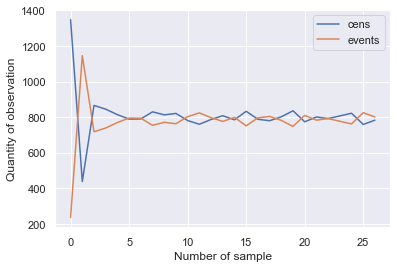

In [827]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(proboost.models)):
    distr = np.bincount(proboost.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

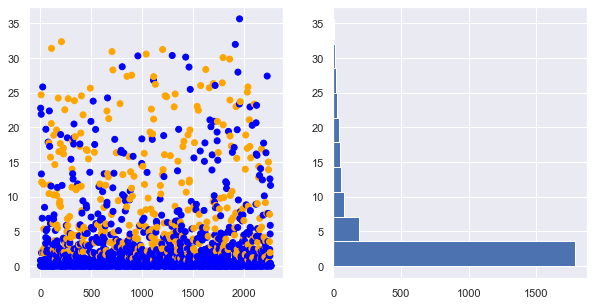

In [828]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(proboost.weights.shape[0]), 
                proboost.weights,
                c = np.where(proboost.y_train["cens"], "orange", "blue"))
axes[1].hist(proboost.weights, orientation="horizontal")
plt.show()

In [829]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [830]:
print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))
print("TRAIN EVENT PR:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1))
print("TRAIN CENS PR:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1))
print("TRAIN WEI=0 PR:", metr.ibs(y_tr, y_tr[np.where(proboost.weights<np.mean(proboost.weights))], 
                                  tr_pred_surv_proboost[np.where(proboost.weights<np.mean(proboost.weights))], bins, axis=-1))
print("TRAIN WEI=0 PR:", metr.ibs(y_tr, y_tr[np.where(proboost.weights>np.mean(proboost.weights))], 
                                  tr_pred_surv_proboost[np.where(proboost.weights>np.mean(proboost.weights))], bins, axis=-1))
print()
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))
print("TEST EVENT PR:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1))
print("TEST CENS PR:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1))

TRAIN PR: 0.06618301959478642
TRAIN EVENT PR: 0.1431745361242169
TRAIN CENS PR: 0.052056505061681295
TRAIN WEI=0 PR: 0.010470846199617577
TRAIN WEI=0 PR: 0.24275880304429945

TEST PR: 0.13154465988590622
TEST EVENT PR: 0.36127351850741285
TEST CENS PR: 0.08939928073265


In [843]:
pred_surv_proboost.shape

(1116, 822)

In [844]:
pred_time_proboost.astype("int").shape

(1116,)

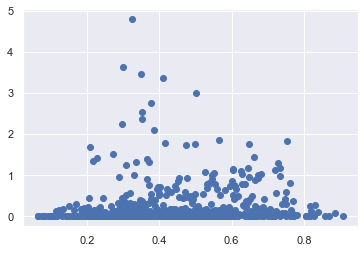

In [847]:
exp_prob = np.take_along_axis(pred_surv_proboost, pred_time_proboost.astype("int")[:, np.newaxis], axis=1)[:, 0]
plt.scatter(exp_prob, metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0))

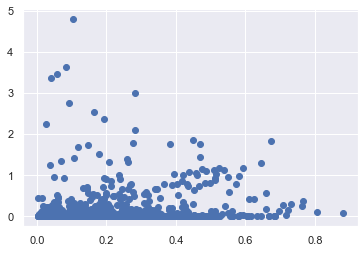

In [837]:
plt.scatter(pred_surv_proboost[:,-1], metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0))

In [893]:
y_HO[srt_idx[::-1]][:10]

array([(False, 821.), (False, 736.), (False, 715.), (False, 709.),
       (False, 821.), ( True, 707.), (False, 762.), (False, 761.),
       ( True, 621.), (False, 821.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [864]:
y_HO.shape[0]

1116

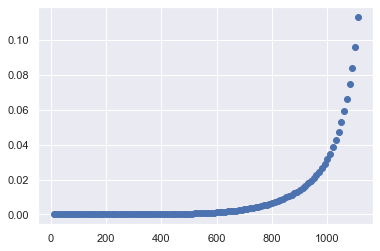

In [867]:
test_ibs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)
srt_idx = np.argsort(test_ibs)

l = []
x = range(10, srt_idx.shape[0], 10)
for i in x:
    l.append(metr.ibs(y_tr, y_HO[srt_idx[:i]], pred_surv_proboost[srt_idx[:i]], bins, axis=-1))
plt.scatter(x, l)

In [871]:
metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0).shape

(1116,)

In [887]:
np.sum(ibs_by_obs > 1)

38

(array([868.,  30.,  12.,  11.,   6.,   8.,   2.,   2.,   3.,   1.]),
 array([0.        , 0.17599146, 0.35198291, 0.52797437, 0.70396582,
        0.87995728, 1.05594873, 1.23194019, 1.40793164, 1.5839231 ,
        1.75991456]),
 <BarContainer object of 10 artists>)

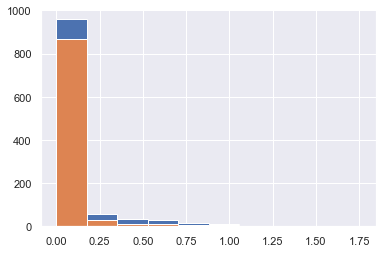

In [890]:
ibs_by_obs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)
plt.hist(np.log(ibs_by_obs+1))
plt.hist(np.log(ibs_by_obs[~y_HO["cens"]]+1))

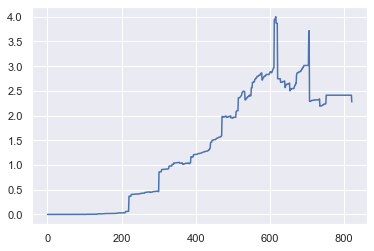

In [856]:
plt.plot(metr.ibs(y_tr, y_t[srt_idx[:10]], pred_surv_proboost[y_HO["cens"]][srt_idx[:10]], bins, axis=1))

In [796]:
y_t = y_HO[y_HO["cens"]]
test_ibs = metr.ibs(y_tr, y_t, pred_surv_proboost[y_HO["cens"]], bins, axis=0)

srt_idx = np.argsort(test_ibs)[::-1]
print(test_ibs[srt_idx][:10])
print(y_t[srt_idx][:10])
print(pred_surv_proboost[y_HO["cens"]][srt_idx][:10])

[1.79298024 1.78996611 1.64164624 1.53702385 1.45642066 1.43333997
 1.31778789 1.25867699 1.17799562 1.14974275]
[( True, 612.) ( True, 471.) ( True, 707.) ( True, 301.) ( True, 220.)
 ( True, 621.) ( True, 705.) ( True, 387.) ( True, 752.) ( True, 579.)]
[[1.         1.         1.         ... 0.71324166 0.71324166 0.65014585]
 [1.         1.         1.         ... 0.66695078 0.66695078 0.65374013]
 [1.         1.         1.         ... 0.34719671 0.34719671 0.34549994]
 ...
 [1.         1.         1.         ... 0.51961412 0.51961412 0.50558311]
 [1.         1.         1.         ... 0.55593309 0.55593309 0.55593309]
 [1.         1.         1.         ... 0.54790666 0.54790666 0.50160675]]


In [783]:
test_ibs[srt_idx]

array([0.        , 0.        , 0.        , ..., 2.02517762, 2.53568889,
       2.87518148])

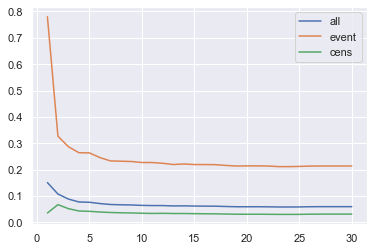

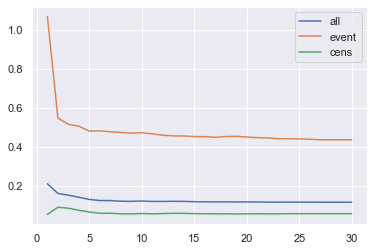

In [774]:
import copy

tr_all = []
tr_event = []
tr_cens = []

tst_all = []
tst_event = []
tst_cens = []

procopy = copy.deepcopy(proboost)
x = list(range(30, 0, -1))
for i in x:
    procopy.select_model(0, i)
    tr_pred = procopy.predict_at_times(X_tr, bins=bins, mode="surv")
    tst_pred = procopy.predict_at_times(X_HO, bins=bins, mode="surv")
    
    tr_all.append(metr.ibs(y_tr, y_tr, tr_pred, bins, axis=-1))
    tr_event.append(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred[y_tr["cens"]], bins, axis=-1))
    tr_cens.append(metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred[~y_tr["cens"]], bins, axis=-1))
    
    tst_all.append(metr.ibs(y_tr, y_HO, tst_pred, bins, axis=-1))
    tst_event.append(metr.ibs(y_tr, y_HO[y_HO["cens"]], tst_pred[y_HO["cens"]], bins, axis=-1))
    tst_cens.append(metr.ibs(y_tr, y_HO[~y_HO["cens"]], tst_pred[~y_HO["cens"]], bins, axis=-1))

plt.plot(x, tr_all, label="all")
plt.plot(x, tr_event, label="event")
plt.plot(x, tr_cens, label="cens")
plt.legend()
plt.show()
plt.plot(x, tst_all, label="all")
plt.plot(x, tst_event, label="event")
plt.plot(x, tst_cens, label="cens")
plt.legend()
plt.show()

In [ ]:
proboost.ibs_means

In [605]:
pred_time_proboost

array([ 20.61344266,  97.325549  , 449.3023549 , ...,  14.23570456,
        42.60921466,  84.91567243])

In [606]:
y_HO["time"]

array([  1.,   7., 357., ...,   2.,  14.,  44.])

In [611]:
res = []
weights = None
if proboost.aggreg_func == "obs_wei":
    weights = [np.zeros(X_HO.shape[0])]
for i in range(len(proboost.models)):
    res.append(proboost.models[i].predict(X_HO, target=cnt.TIME_NAME))
    if proboost.aggreg_func == "obs_wei":
        weights.append(proboost.models[i].get_ibs_by_leaf(X_HO))

res = np.array(res)
if proboost.aggreg_func == "obs_wei":
    weights = np.vstack(weights[:-1]).T
    weights = np.cumsum(weights, axis=1)
    weights = norm.cdf((weights - np.array(proboost.ibs_means)) / np.array(proboost.ibs_stds))

In [757]:
print(np.mean(proboost.weights[proboost.y_train["cens"]]))
print(np.mean(proboost.weights[~proboost.y_train["cens"]]))

9.311282092007119
1.7253787145420514


In [617]:
weights[1]

array([0.5       , 0.65882212, 0.75576912, 0.67123547, 0.66340646,
       0.56999353, 0.4820908 , 0.43119368, 0.39712532, 0.37137517,
       0.3804177 , 0.39086582, 0.46635157, 0.43576438, 0.41004133,
       0.42703959, 0.50086209, 0.51558803, 0.55835329, 0.52395362,
       0.49195177, 0.47727851, 0.4593069 , 0.43744934, 0.42408918,
       0.41439572, 0.40111487, 0.38275273, 0.39157805, 0.37727791])

In [613]:
res[:, 1]

array([ 88.5689621 , 101.        ,  94.26316071, 106.09889984,
        76.57142639, 141.1000061 ,  67.63636017,  51.80625153,
        53.77777863,  51.8571434 , 115.36842346,  85.1818161 ,
        48.16666794,  49.        , 114.69999695, 117.83333588,
        79.33333588,  89.83333588,  85.25      , 203.66667175,
        53.        ,  95.85713959, 131.75      , 148.1000061 ,
        65.        , 104.44444275, 200.83332825,  72.875     ,
       164.5       ,  49.57143021])

In [614]:
np.sum((res.T*1/weights).T, axis=0) / np.sum(1/weights, axis=1)

array([ 20.25475238,  96.44154524, 451.50193452, ...,  14.86393937,
        39.92787486,  84.87878912])

In [755]:
pred_time_proboost

array([ 35.3370864 , 115.69807324, 611.74538324, ...,  49.64225843,
        82.4029887 , 155.1648781 ])

In [756]:
y_HO

array([(False,   1.), ( True,   7.), (False, 357.), ..., (False,   2.),
       (False,  14.), (False,  44.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [29]:
from pkg_resources import resource_filename
import h5py
import pandas as pd
import numpy as np

def _load_dataset(filename, partition='complete', data_type='pandas', **kwargs):
    filename_ = filename
    
    # Read training data.
    with h5py.File(filename_, 'r') as f:
        X_train = f['train']['x'][()]
        E_train = f['train']['e'][()]
        Y_train = f['train']['t'][()].reshape(-1, 1)
    
    # Read testing data.
    with h5py.File(filename_, 'r') as f:
        X_test = f['test']['x'][()]
        E_test = f['test']['e'][()]
        Y_test = f['test']['t'][()].reshape(-1, 1)
        
    # Define data partitions.
    if partition == 'training' or partition == 'train':
        X = X_train
        Y = Y_train
        E = E_train
    elif partition == 'testing' or partition == 'test':
        X = X_test
        Y = Y_test
        E = E_test
    elif partition == 'complete':
        X = np.concatenate((X_train, X_test), axis=0)
        Y = np.concatenate((Y_train, Y_test), axis=0)
        E = np.concatenate((E_train, E_test), axis=0)
    else:
        raise ValueError('Invalid partition.')

    # If NumPy, do nothing (already in that format).
    if (data_type == 'numpy') or (data_type=='np') or (data_type=='array'):
        pass
    
    # Otherwise, convert to pandas DataFrame.
    elif (data_type == 'pandas') or (data_type=='pd') or (data_type=='dataframe') or (data_type=='df'):
        X, Y, E = _numpy_to_pandas(X, Y, E, filename)
        
    else:
        raise ValueError("Invalid data type.")
        
    return X, Y, E

def _numpy_to_pandas(X, Y, E, filename):
    # Get columns names and data types.
    column_names = _get_column_names(filename)
    data_types = _get_data_types(filename)
    
    # Create pandas DataFrames
    df_X = pd.DataFrame(data=X, columns=column_names)
    df_X = df_X.astype(data_types)
    
    df_Y = pd.DataFrame(data=Y, columns=['T'], dtype=np.float64)
    df_E = pd.DataFrame(data=E, columns=['E'], dtype=np.int32)
    
    return df_X, df_Y, df_E

def _get_column_names(filename):
    """
    Get the data column names (needed to create a pandas DataFrame).
    
    Parameters
    ----------
    filename: string
        Name of the dataset (e.g., 'whas.h5')
        
    Returns
    -------
    column_names: list
        Column names corresponding to the data.
    """
    # Remove file name extension.
    filename = filename.split('.h5')[0]

    # Define column names for each dataset.
    if filename=='metabric':
        column_names = ['gene1', 'gene2', 'gene3', 'gene4', 'radio', 'horm', 'chemo', 'er_status', 'age']
    elif filename=='rgbsg':
        column_names = ['horm_treatment', 'grade', 'menopause' ,'age' ,'n_positive_nodes', 'progesterone' ,'estrogen']
    elif filename=='simulated_gaussian':
        column_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
    elif filename=='simulated_linear':
        column_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
    elif filename=='simulated_treatment':
        column_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'treatment']
    elif filename=='support':
        column_names = ['age', 'sex', 'race', 'n_comorbidities', 'diabetes', 'dementia', 'cancer', 'blood_pressure', 'heart_rate', 'respiration_rate', 'temperature', 'white_blood_cell', 'serum_sodium', 'serum_creatinine']
    elif filename=='whas':
        column_names = ['shock', 'age', 'sex', 'bmi', 'chf', 'recurrent']
    
    return column_names



#%%
def _get_data_types(filename):
    """
    Get the right data types of the columns (needed to create a pandas DataFrame).
    
    Parameters
    ----------
    filename: string
        Name of the dataset (e.g., 'whas.h5')
        
    Returns
    -------
    data_types: dictionary
        Each key corresponds to the column name.
        Each value corresponds to the data type.
    """
    # Remove file name extension.
    filename = filename.split('.h5')[0]
    
    # Assign data type for each column for each dataset.
    if filename=='metabric':
        data_types_ = ['float64', 'float64', 'float64', 'float64', 'int32', 'int32', 'int32', 'int32', 'float64']
    elif filename=='rgbsg':
        data_types_ = ['int32', 'int32', 'int32', 'int32' ,'int32', 'int32', 'int32']
    elif filename=='simulated_gaussian':
        data_types_ = ['float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64']
    elif filename=='simulated_linear':
        data_types_ = ['float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64']
    elif filename=='simulated_treatment':
        data_types_ = ['float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'int32']
    elif filename=='support':
        data_types_ = ['float64', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'float64', 'int32', 'float64', 'float64']
    elif filename=='whas':
        data_types_ = ['int32', 'int32', 'int32', 'float64', 'int32', 'int32']
    
    # Create dictionary.
    keys = _get_column_names(filename)
    data_types = dict(zip(keys, data_types_))
    
    return data_types

In [30]:
X, Y, E = _load_dataset('support.h5')

In [34]:
np.histogram(Y)

(array([4297,  902,  875,  755,  567,  255,  278,  330,  315,  299],
       dtype=int64),
 array([   3. ,  205.6,  408.2,  610.8,  813.4, 1016. , 1218.6, 1421.2,
        1623.8, 1826.4, 2029. ]))

In [42]:
np.bincount(E.values[:, 0])

array([2837, 6036], dtype=int64)

In [45]:
X.columns.shape

(14,)

### New medical datasets
[https://github.com/ErikinBC/SurvSet/tree/main](SOURCE)

NAME: support2
SHAPE: (9105, 38)
CENS_DISTR: [2904 6201]


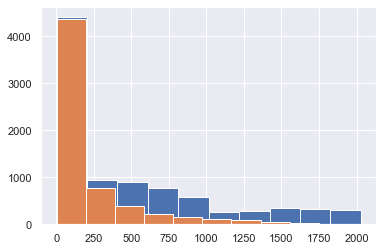

NAME: flchain
SHAPE: (7874, 13)
CENS_DISTR: [5705 2169]


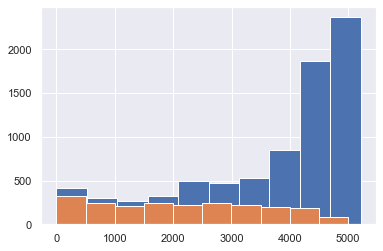

NAME: smarto
SHAPE: (3873, 29)
CENS_DISTR: [3413  460]


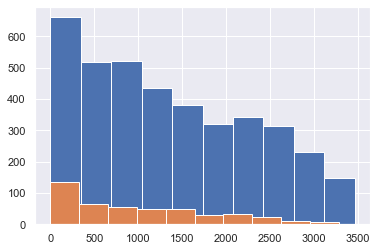

NAME: rott2
SHAPE: (2982, 14)
CENS_DISTR: [1710 1272]


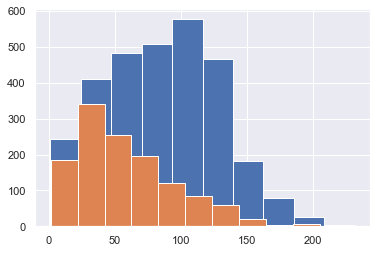

In [75]:
from SurvSet.data import SurvLoader
loader = SurvLoader()

for name in ['support2', 'flchain', 'smarto', 'rott2']:
    print(f"NAME: {name}")
    df, ref = loader.load_dataset(ds_name=name).values()
    print(f"SHAPE: {df.shape}")
    print(f'CENS_DISTR: {np.bincount(df["event"])}')
    plt.hist(df["time"])
    plt.hist(df[df["event"]==1]["time"])
    plt.show()